# NYC Taxi Rides
In this project, I analyze New York City taxi data and make predictions on taxi ride duration times.

In [1]:
%matplotlib inline
import os
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as lm
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
sns.set(style="whitegrid", palette="muted")
from sqlalchemy import create_engine
from utils import timeit
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 12
%matplotlib inline

# 1. The Data

First, we begin by loading the data.

In [2]:
!ls -lh /srv/db/taxi_2016_student_small.sqlite

-rw-r--r-- 1 root root 2.1G Nov 27 07:32 /srv/db/taxi_2016_student_small.sqlite


In [3]:
DB_URI = "sqlite:////srv/db/taxi_2016_student_small.sqlite"
TABLE_NAME = "taxi"

sql_engine = create_engine(DB_URI)
with timeit():
    print(f"Table {TABLE_NAME} has {sql_engine.execute(f'SELECT COUNT(*) FROM {TABLE_NAME}').first()[0]} rows!")

Table taxi has 15000000 rows!
1.00 s elapsed


Below we filter out taxi rides that occured during the big storm in January of 2016.

In [4]:
query1 = f"""
            SELECT * 
            FROM {TABLE_NAME}
            WHERE tpep_pickup_datetime
                BETWEEN '2016-02-01' AND '2016-04-30'
                AND record_id % 100 == 0
            ORDER BY tpep_pickup_datetime
            """
with timeit():
    data = pd.read_sql_query(query1, sql_engine)

3.06 s elapsed


Ignore this part below. We will use this later.

In [5]:
query2 = f"""
            SELECT * 
            FROM {TABLE_NAME}
            WHERE tpep_pickup_datetime
                AND record_id % 100 == 0
            ORDER BY tpep_pickup_datetime
            """
with timeit():
    all_data = pd.read_sql_query(query2, sql_engine)

3.90 s elapsed


Aadding a duration column to the training dataset.

In [6]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [7]:
data['duration'] = data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]
data['duration'] = data['duration'].dt.total_seconds()
data = data[data['duration'] < 12 * 3600]

In [8]:
data.shape

(75396, 21)

## 1.2 The Stats

Below is the statistical summary of the data.

In [9]:
data.describe()

,record_id,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
count,7.539600e+04,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000,75396.000000
mean,2.849081e+07,1.530068,1.657595,2.929089,-72.853346,40.133951,1.074739,-72.891522,40.155681,1.340761,12.741845,0.338980,0.497238,1.786719,0.310740,0.299610,15.975131,821.843944
std,1.013156e+07,0.499098,1.307959,3.602263,9.035067,4.977352,1.908449,8.881745,4.892979,0.491848,11.071461,0.452275,0.039643,2.496170,1.441743,0.013728,13.627351,677.299095
min,1.090710e+07,1.000000,0.000000,0.000000,-77.807198,0.000000,1.000000,-77.039436,0.000000,1.000000,-52.000000,-4.500000,-0.500000,0.000000,0.000000,-0.300000,-57.300000,-16.000000
25%,1.971725e+07,1.000000,1.000000,1.000000,-73.991669,40.736443,1.000000,-73.991196,40.734812,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.500000,391.000000
50%,2.847560e+07,2.000000,1.000000,1.700000,-73.981453,40.753426,1.000000,-73.979469,40.753880,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,654.000000
75%,3.729255e+07,2.000000,2.000000,3.110000,-73.966507,40.767995,1.000000,-73.962349,40.769169,2.000000,14.500000,0.500000,0.500000,2.360000,0.000000,0.300000,17.760000,1058.000000
max,4.643400e+07,2.000000,6.000000,55.600000,0.000000,44.932213,99.000000,0.000000,41.247791,4.000000,429.000000,4.500000,0.500000,160.000000,57.750000,0.300000,487.050000,37874.000000


## 1.3 Cleaning the Data

Everything looks pretty good; however, the `duration` stands out. The `duration` column is measured in seconds. The `min` is -16 seconds and the `max` is 149,481 seconds (41.5 hrs). Let's go ahead and remove all the taxi rides that have a negative `duration` because this is likely due to an error.

In [10]:
cleaned_data = data[data['duration'] >= 0]
cleaned_data = data[data['duration'] < 10000]
cleaned_data.shape

(75389, 21)

Next, we want filter out any taxi ride that is not within the bounds of the New York City region.

In [11]:
cleaned_data = cleaned_data[cleaned_data['pickup_longitude'] <= -73.75]
cleaned_data = cleaned_data[cleaned_data['pickup_longitude'] >= -74.03]
cleaned_data = cleaned_data[cleaned_data['pickup_latitude'] <= 40.85]
cleaned_data = cleaned_data[cleaned_data['pickup_latitude'] >= 40.63]
cleaned_data = cleaned_data[cleaned_data['dropoff_longitude'] <= -73.75]
cleaned_data = cleaned_data[cleaned_data['dropoff_longitude'] >= -74.03]
cleaned_data = cleaned_data[cleaned_data['dropoff_latitude'] <= 40.85]
cleaned_data = cleaned_data[cleaned_data['dropoff_latitude'] >= 40.63]
cleaned_data.shape

(73127, 21)

Also, the `passenger_count` column has a minimum of 0, which doesn't make sense. So now we remove all taxi rides with 0 passengers.

In [12]:
cleaned_data = cleaned_data[cleaned_data['passenger_count'] > 0]
cleaned_data.shape

(73126, 21)

In [13]:
num_records_removed = data.shape[0] - cleaned_data.shape[0]
proportion_records_removed = num_records_removed / data.shape[0]
txt = f"""Number of records removed: {num_records_removed} 
Proportion of records removed: {proportion_records_removed}"""
print(txt)

Number of records removed: 2270 
Proportion of records removed: 0.030107698021115178


## Below we send the code away for part 4.

In [14]:
Path("data/final").mkdir(parents=True, exist_ok=True)
data_file = Path("data/final", "cleaned_data.hdf") # Path of hdf file
cleaned_data.to_hdf(data_file, "cleaned_data") # Train data of hdf file/

## 1.4 Test Train Split

In [15]:
train_df, test_df = train_test_split(cleaned_data, test_size=0.2, random_state=42)

In [16]:
train_df.shape, test_df.shape

((58500, 21), (14626, 21))

# 2. EDA on Taxi Data

Let's begin the EDA process by looking at ride `duration` in a histogram. 

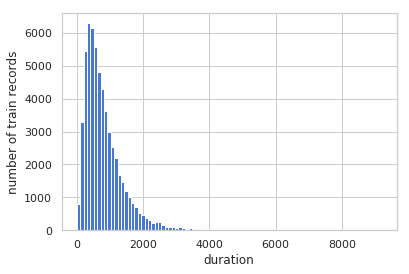

In [17]:
plt.hist(train_df['duration'], bins=90)
plt.xlabel('duration')
plt.ylabel('number of train records')
plt.show()

Below I apply a log transformation to the data.

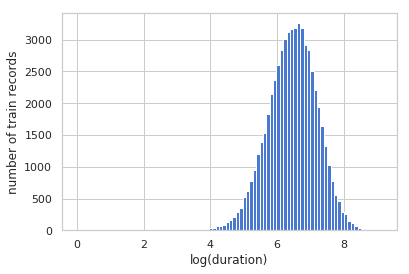

In [18]:
log_dur = np.log(train_df['duration'] + 1)
plt.hist(log_dur, bins=90)
plt.xlabel('log(duration)')
plt.ylabel('number of train records')
plt.show()

## Adding time columns

In [19]:
train_df.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(train_df['tpep_pickup_datetime'])
test_df.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])

train_df.loc[:, 'pickup_date'] = train_df.loc[:, 'tpep_pickup_datetime'].dt.date
test_df.loc[:, 'pickup_date'] = test_df.loc[:, 'tpep_pickup_datetime'].dt.date

train_df.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(train_df.loc[:, 'tpep_dropoff_datetime'])
test_df.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(test_df.loc[:, 'tpep_dropoff_datetime'])
all_data.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(all_data['tpep_pickup_datetime'])

train_df.loc[:, 'day_of_week'] = train_df.loc[:, 'tpep_pickup_datetime'].dt.dayofweek
test_df.loc[:, 'day_of_week'] = test_df.loc[:, 'tpep_pickup_datetime'].dt.dayofweek

all_data.loc[:, 'pickup_date'] = all_data.loc[:, 'tpep_pickup_datetime'].dt.date
all_data.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(all_data.loc[:, 'tpep_dropoff_datetime'])

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


## 2.2 Removing More Outliers

Next, let's look at the number of rides over time.

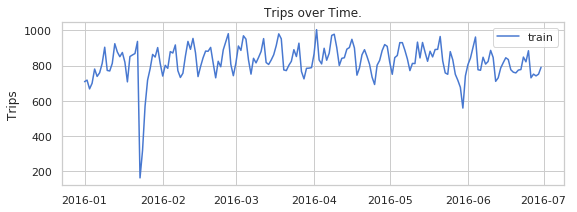

In [20]:
plt.figure(figsize=(9,3))
plt5 = plt.plot(all_data.groupby('pickup_date').count()[['record_id']], '-', label='train')
plt5 = plt.title('Trips over Time.')
plt5 = plt.legend(loc=0)
plt5 = plt.ylabel('Trips')
plt.show()

fig = plt5.get_figure()
fig.savefig('all_months.png')

As you can see in the plot above, the storm causes a massive drop in rides. This would throw off the accuracy of our model, so we want to bring that drop as close to the 'pipeline' of the data as possible as this is a pretty unusual experience. There is also a drop in late May 2016, which probably correlates to Memorial Day Weekend. Selecting dates from February to April avoids these outliers.

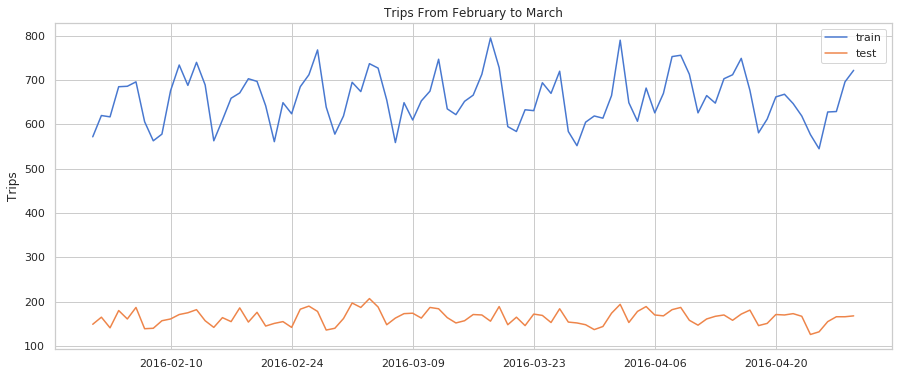

In [21]:
plt.figure(figsize=(15,6))
plt6 = plt.plot(train_df.groupby('pickup_date').count()[['record_id']], '-', label='train')
plt6 = plt.plot(test_df.groupby('pickup_date').count()[['record_id']], '-', label='test')
plt6 = plt.title('Trips From February to March')
plt6 = plt.legend(loc=0)
plt6 = plt.ylabel('Trips')
plt.show()

fig = plt6.get_figure()
fig.savefig('my_months.png')

It might also help to talk a look at ride `duration` vs `day_of_week`.

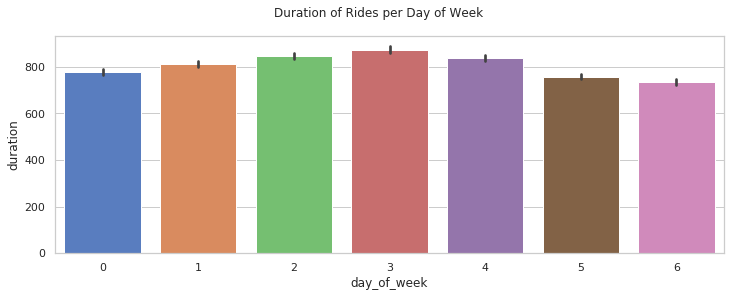

In [22]:
plt.figure(figsize=(12,4))
plt1 = sns.barplot(x='day_of_week', y='duration', data=train_df)
plt.suptitle("Duration of Rides per Day of Week")
plt.show()

fig = plt1.get_figure()
fig.savefig('duation of rides per day of week.png')

# 3. Feature Engineering

Let's start by looking at different distance functions.

## 3.1 Distance

Below we define a couple distance methods we will be comparing.

In [23]:
# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

In [24]:
train_df = add_time_columns(train_df)
train_df = add_distance_columns(train_df)
test_df = add_time_columns(test_df)
test_df = add_distance_columns(test_df)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


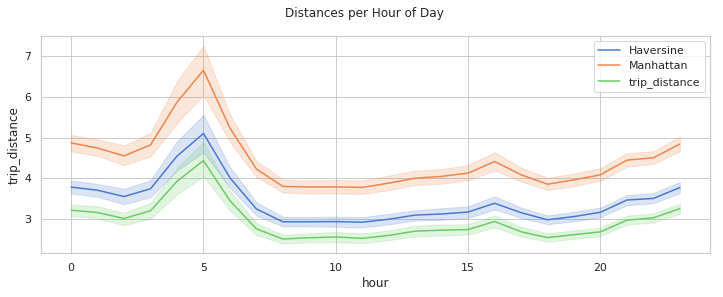

In [25]:
plt.figure(figsize=(12,4))
sns.lineplot(x='hour', y='haversine', data=train_df, label="Haversine")
sns.lineplot(x='hour', y='manhattan', data=train_df, label="Manhattan")
sns.lineplot(x='hour', y='trip_distance', data=train_df, label="trip_distance")
plt.suptitle("Distances per Hour of Day")
plt.legend()
plt.show()

Below I check to see if the price of the taxi ride has anything to do with its duration.

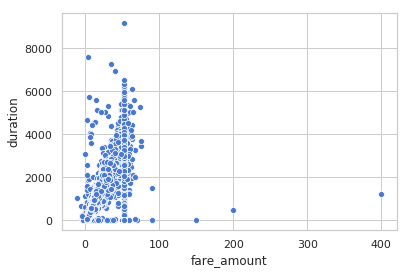

In [26]:
plt3 = sns.scatterplot(x='fare_amount', y='duration', data=train_df)
plt.show()

fig = plt3.get_figure()
fig.savefig('b4log.png')

This doesn't look too helpful, so below I look at the log of the price to see if we can get a more normal distribution.

In [27]:
train_df['fare_amount'] = np.log(np.abs(train_df['fare_amount']) + 1)
test_df['fare_amount'] = np.log(np.abs(test_df['fare_amount']) + 1)

train_df['total_amount'] = np.log(np.abs(train_df['total_amount']) + 1)
test_df['total_amount'] = np.log(np.abs(test_df['total_amount']) + 1)

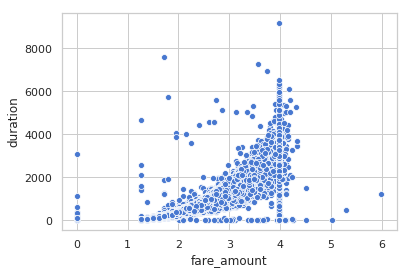

In [28]:
plt4 = sns.scatterplot(x='fare_amount', y='duration', data=train_df)
plt.show()

fig = plt4.get_figure()
fig.savefig('afterlog.png')

In [29]:
train_end = train_df
test_end = test_df

## 3.2 One-Hot-Encoding

Let's search for some more features. As we saw in part 2, `day_of_week` may have something to do with ride durations. Now, I do some one-hot-encoding to select more features.

In [30]:
dow_train = pd.get_dummies(train_df['day_of_week'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test_df['day_of_week'], prefix='dow', prefix_sep='_')

month_train = pd.get_dummies(train_df['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test_df['month'], prefix='m', prefix_sep='_')

hour_train = pd.get_dummies(train_df['hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test_df['hour'], prefix='h', prefix_sep='_')

store_train = pd.get_dummies(train_df['store_and_fwd_flag'], prefix='h', prefix_sep='_')
store_test = pd.get_dummies(test_df['store_and_fwd_flag'], prefix='h', prefix_sep='_')

## 3.3 Combining the Data

Features we might want to use at are `trip_distance`, `haversine`, `hour`, `month`, `day_of_week`, and `bearing` (direction). Below, we get rid of all the categorical data that we will not use in our model.

In [31]:
# storing `duration` columns for later
train_response = train_df['duration']
test_response = test_df['duration']

In [32]:
train_df = train_df.drop(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'duration',
       'pickup_date', 'week_of_year', 'day_of_month', 'week_hour', 'month',
        'day_of_week', 'hour'], axis=1)

test_df = test_df.drop(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge',
       'pickup_date', 'week_of_year', 'day_of_month', 'week_hour', 'month',
        'day_of_week', 'hour', 'duration'], axis=1)

print(train_df.shape)
print(test_df.shape)

(58500, 5)
(14626, 5)


In [33]:
# Combining dummies with trest and train dataset

Train_Master = pd.concat([train_df, dow_train, month_train, hour_train, store_train], axis=1)
Test_Master = pd.concat([test_df, dow_test, month_test, hour_test, store_test], axis=1)

print(Train_Master.shape)
print(Test_Master.shape)

(58500, 41)
(14626, 41)


# 4.1 Building a Model

Below, we create and define our model that predicts a taxi ride's `duration`.

## 4.1.1 

In [34]:
linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(Train_Master, train_response)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
pred_response = linear_model.predict(Train_Master)

In [36]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [37]:
train_error = mae(train_response, linear_model.predict(Train_Master))
test_error = mae(test_response, linear_model.predict(Test_Master))
print("Training error: ", train_error)
print("Testing error: ", test_error)

Training error:  149.740987617
Testing error:  151.133119474


# Data Pipeline

I will now encapsulate my entire pipeline into a single function process_data_gm. gm is shorthand for "guided model".

In [38]:
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

In [39]:
def process_data_gm1(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        .pipe(select_columns,        
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'manhattan',
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y

I will use my pipeline defined above to pre-process my training and test data in exactly the same way. The functions make this relatively easy to do!

In [40]:
# Train
X_train, y_train = process_data_gm1(train_end)
X_val, y_val = process_data_gm1(test_end)
guided_model_1 = lm.LinearRegression(fit_intercept=True)
guided_model_1.fit(X_train, y_train)

# Predict
y_train_pred = guided_model_1.predict(X_train)
y_val_pred = guided_model_1.predict(X_val)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


The resulting model really is a linear model, i.e. the predictions are simply generated by the product $\Phi\theta$. For example, the line of code below generates a prediction for $x_1$ by computing $\phi_1^T\theta$. Here `guided_model_1.coef_` is $\theta$ and `X_train.iloc[0, :]` is $\phi_1$.

Note that here the dummy intercept term is not included in $\Phi$. 

In [41]:
X_train.iloc[0, :].dot(guided_model_1.coef_) + guided_model_1.intercept_

545.48453622261877

In [42]:
y_train_pred[0]

545.48453622258967

 I will use Mean Absolute Error (MAE), a.k.a. mean L1 loss, to measure the quality of my model.
 
 $$
MAE =\frac{1}{n}\sum_{i}  | y_i -\hat{y_i}|
$$

Using domain knowledge that most rides are short in duration (median is roughly 600 seconds), we know that MSE is susceptible to outliers. Given that some of the outliers in our dataset are quite extreme, it is probably better to optimize for the majority of rides rather than for the outliers.

In [43]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

## Visualizing Error
The error should be between 200 and 300 MAE, which means the model was off by roughly 3-5 minutes on trips of average length 12 minutes. This is fairly decent performance given that the basic model uses only using the pickup/dropoff latitude and manhattan distance of the trip. 3-5 minutes may seem like a lot for a trip of 12 minutes, but keep in mind that this is the *average* error. This metric is susceptible to extreme outliers, which exist in the dataset. 

Now I will visualize the residual for the validation set and plot the following:

1. Distribution of residuals
2. Average residual grouping by ride duration

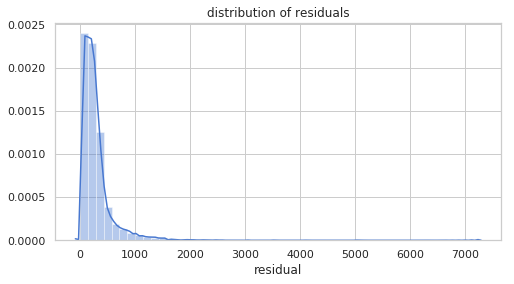

In [44]:
plt.figure(figsize=(8,4))
sns.distplot(np.abs(y_val - y_val_pred))
plt.xlabel('residual')
plt.title('distribution of residuals');

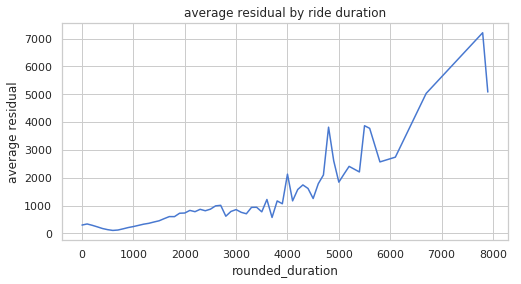

In [45]:
# Average residual grouping by ride duration
val_residual = X_val.copy()
val_residual['duration'] = y_val
val_residual['rounded_duration'] = np.around(y_val, -2)
val_residual['residual'] = np.abs(y_val - y_val_pred)
tmp = val_residual.groupby('rounded_duration').mean()
plt.figure(figsize=(8,4))
tmp['residual'].plot()
plt.ylabel('average residual')
plt.title('average residual by ride duration');